# Timeseries analysis of temperature

* **Products used:** 
[ERA5](https://registry.opendata.aws/ecmwf-era5/),
[ls5_st](https://explorer.digitalearth.africa/ls5_st),
[ls8_st](https://explorer.digitalearth.africa/ls8_st)

The ERA5 dataset is external to the Digital Earth Africa platform.

## Background

We may be interested in how an environmental variable has changed or trended over a medium or long-term period. Timeseries decomposition can help us visualise long-term trends in geospatial variables. The technique decomposes a timeseries into its cyclical (seasonal), trend, and residual error components. 

## Description
For this example, we will load air and surface temperature data. The spatial resolution of surface temperature data allows us to visualise spatial patterns between timepoints. Conversely, the temporal regularity of ERA5 air temperature data means it is better suited to analysis of a one-dimensional timeseries.

The notebook outlines:

1. Loading ERA5 air temperature and Landsat surface temperature data.
2. Plot and inspect surface temperature at two time points. 
3. Decomposing a timeseries of air temperature data into trend, seasonal, and random error components.
3. Plotting and interpreting seasonal and trend components of timeseries.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.load_era5 import load_era5
from deafrica_tools.plotting import display_map, rgb
from statsmodels.tsa.seasonal import seasonal_decompose

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Timeseries_temperature")

### Analysis parameters

We will load temperature data for a forty year period (1981-2021) for the default location of Cairo, Egypt.

The following cell sets important parameters for the analysis:

* `lat`: range of latitude we wish to cover.
* `lon`: range of longitude we wish to cover.
* `time`: time period

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.


In [3]:
# Area around Cairo
lat = (29.881, 30.328)
lon = (31.078, 31.662)

# Define the time window
time = "1981-01", "2021-12"

display_map(x=lon, y=lat)

## Load temperature data

We will use the `load_era5` function to get air temperature at a height of 2m for the period and area of interest. We resample this dataset to monthly mean values as we load, so the dataset size is more manageable.

We will also use `load_ard` to get land surface temperature from Landsats 5 and 8, and `dc.load` to retrieve Landsat geomedians so we can compare true colour images to surface temperature.

### Load air temperature

In [4]:
var = "air_temperature_at_2_metres"

temp = load_era5(var, lat, lon, time, reduce_func=np.mean, resample="1M").compute()

In [5]:
attrs = temp[var].attrs
attrs["units"] = "C"
temp = temp - 273.15  # convert from Kelvin to Celcius
temp[var].attrs = attrs

### Load Landsat surface temperature and surface reflectance

In [6]:
surf_temp_84 = load_ard(
    dc=dc,
    products=["ls5_st"],
    x=lon,
    y=lat,
    time=["1984"],
    measurements=["surface_temperature"],
    output_crs="EPSG:32633",
    resolution=(-30, 30),
    dask_chunks={"x": 3000, "y": 3000},
)

surf_temp_84 = (
    surf_temp_84.resample(time="1Y").mean() - 273.15
)  # resample to annual mean values and convert from K to C

surf_temp_20 = load_ard(
    dc=dc,
    products=["ls8_st"],
    x=lon,
    y=lat,
    time=["2020"],
    measurements=["surface_temperature"],
    output_crs="EPSG:32633",
    resolution=(-30, 30),
    dask_chunks={"x": 3000, "y": 3000},
)

surf_temp_20 = (
    surf_temp_20.resample(time="1Y").mean() - 273.15
)  # resample to annual mean values and convert from K to C

surf_refl_84 = dc.load(
    product=["gm_ls5_ls7_annual"],
    x=lon,
    y=lat,
    time=["1984"],
    measurements=["red", "green", "blue"],
    output_crs="EPSG:32633",
    resolution=(-30, 30),
    dask_chunks={"x": 3000, "y": 3000},
)

surf_refl_20 = dc.load(
    product=["gm_ls8_annual"],
    x=lon,
    y=lat,
    time=["2020"],
    measurements=["red", "green", "blue"],
    output_crs="EPSG:32633",
    resolution=(-30, 30),
    dask_chunks={"x": 3000, "y": 3000},
)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls5_st
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 22 time steps as a dask array
Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_st
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 45 time steps as a dask array


## Inspect changes in surface temperature

Plotting surface temperature alongside true colour images below shows how spatial patterns in surface temperature have changed between 1984 and 2020, and how they may relate to changes in land use and land cover. Addition of some vegetation and presumably irrigation in the eastern part of the area has produced lower surface temperature in 2020 compared with 1984. However, loss of vegetation and infrastructure development in other areas appears to have increased surface temperature.

/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


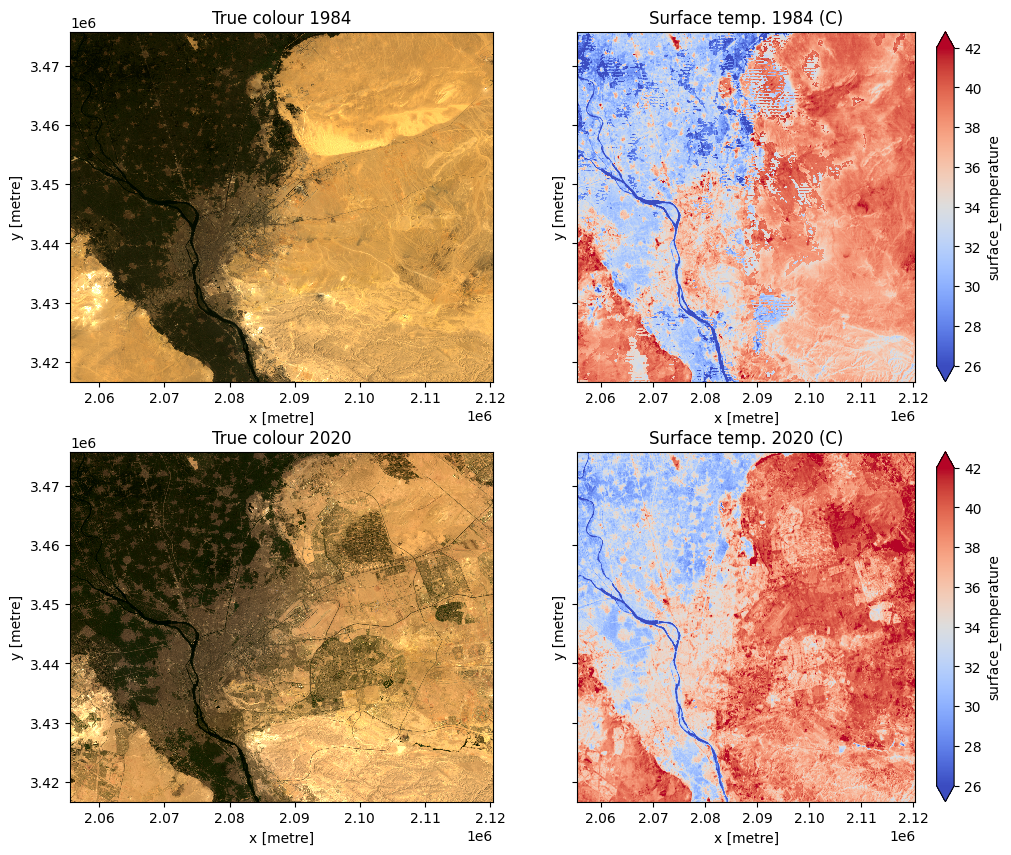

In [7]:
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(12, 10))
rgb(surf_refl_84, ax=ax[0, 0])
rgb(surf_refl_20, ax=ax[1, 0])
surf_temp_84.surface_temperature.plot(
    ax=ax[0, 1], cmap="coolwarm", robust=True, vmin=26, vmax=42
)
surf_temp_20.surface_temperature.plot(
    ax=ax[1, 1], cmap="coolwarm", robust=True, vmin=26, vmax=42
)
ax[0, 0].set_title("True colour 1984")
ax[1, 0].set_title("True colour 2020")
ax[0, 1].set_title("Surface temp. 1984 (C)")
ax[1, 1].set_title("Surface temp. 2020 (C)");

## Inspect air temperature timeseries

Below, the observed timeseries of air temperature is plotted. Are there any noticeable trends or anomalies?

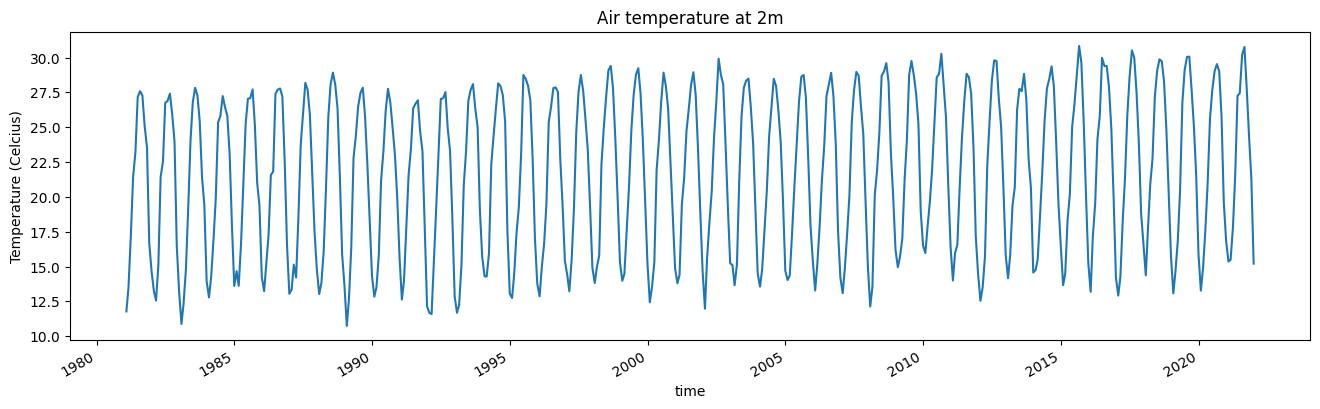

In [8]:
temp[var].mean(["lat", "lon"]).plot(figsize=(16, 4))
plt.title("Air temperature at 2m")
plt.ylabel("Temperature (Celcius)");

## Timeseries decomposition

The next step is to decompose the observed timeseries into its seasonal and trend components. The `seasonal_decompose` function works best on pandas timeseries, so we will spatially aggregate our timeseries and convert it to a pandas dataframe.

In [9]:
temp_air_ts = temp[var].mean(['lat','lon']).to_pandas()

Now we can use the `seasonal_decompose` function on our timeseries. Details on the function are available in the [package notes](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) and general timeseries decomposition is available [here](https://en.wikipedia.org/wiki/Decomposition_of_time_series).

The result of decomposition is plotted below which shows the observed timeseries (shown above), the trend component (note difference in y-axis scale), the seasonal (or cyclical) component, and the residual error.

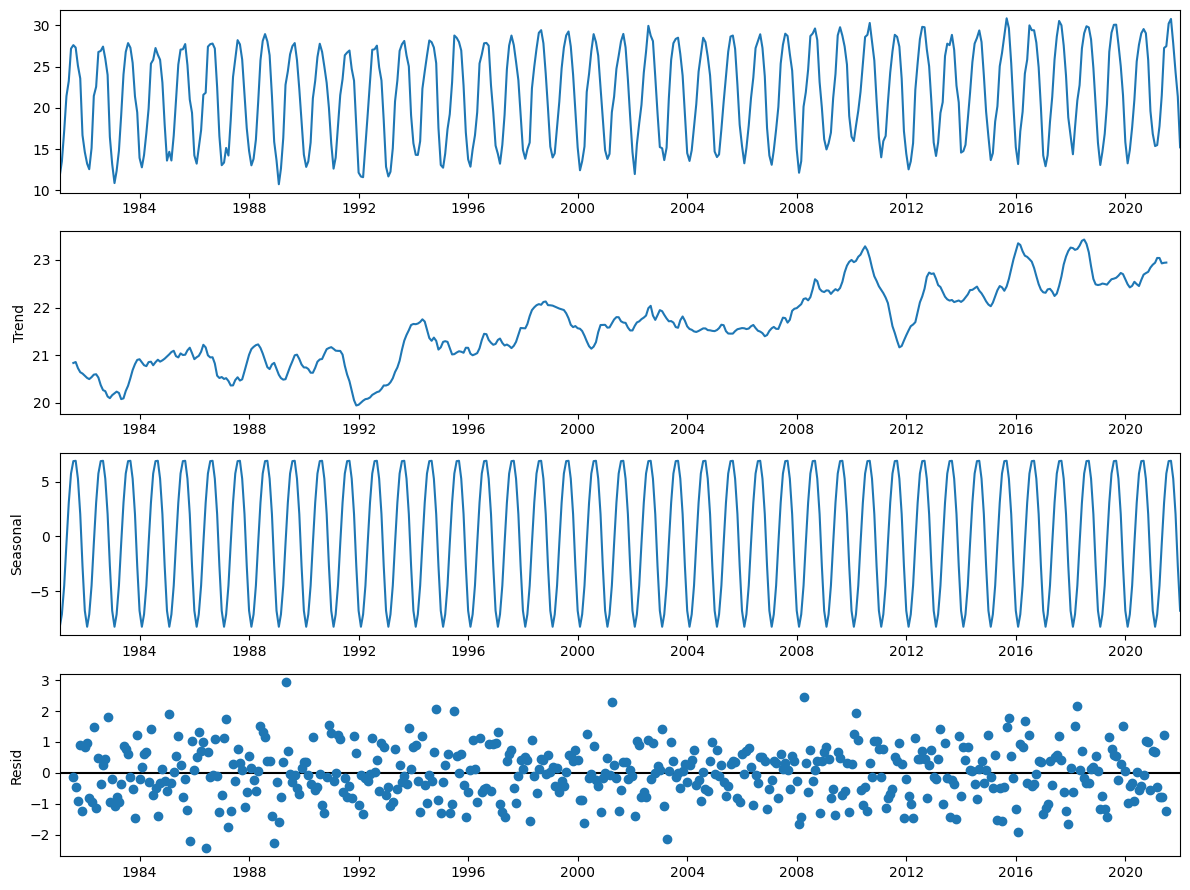

In [10]:
temp_air_dts = seasonal_decompose(temp_air_ts)

fig = temp_air_dts.plot()
fig.set_size_inches((12, 9))
fig.tight_layout()
plt.show()

We can also plot individual components, such as the long term trend, as below, and make comparisons between air and surface temperature. 

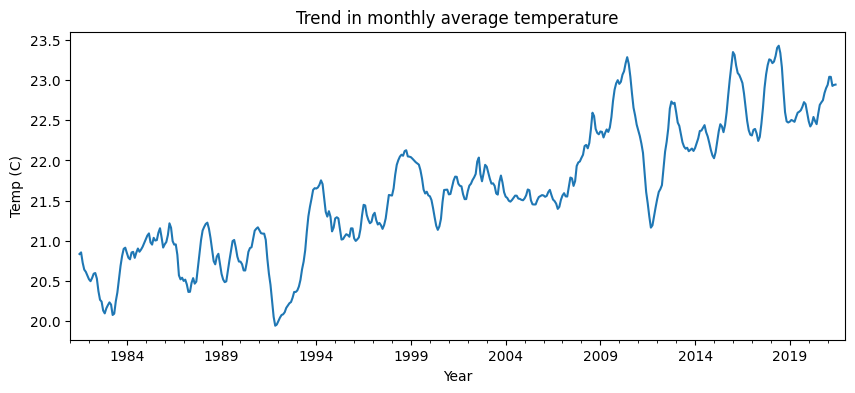

In [11]:
temp_air_dts.trend.plot(figsize = (10,4))
plt.xlabel('Year')
plt.ylabel('%s (%s)'%('Temp', temp[var].attrs['units']))
plt.title('Trend in monthly average temperature');

## Interpretation and next steps

The exploratory analysis conducted in this notebook allows us to visually examine trends and seasonal patterns. We would need to conduct further statistical test to determine whether any observed trends could be considered 'significant'. 

We are also unable to draw any causal inferences about observed trends from this analysis alone. We might hypothesise that the increasing air temperature trend is due to some combination of increasing atmospheric greenhouse gas concentration and the changes in land use and land cover observed.

Further analysis would be required to attribute the trends to any of these factors. 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.8.12


**Last Tested:**

In [13]:
from datetime import datetime

datetime.today().strftime('%Y-%m-%d')

'2023-05-03'